# Get the Data
Our task is to  build a model that predicts the total ride duration of taxi trips in New York City.

In [2]:
import numpy as np
import pandas as pd
import gc

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import seaborn as sns

### Load Data

In [3]:
import zipfile
import os

zip_path = '/kaggle/input/nyc-taxi-trip-duration/train.zip'

extract_path = '/content/extracted_folder/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
csv_path = os.path.join(extract_path, 'train.csv')
taxi = pd.read_csv(csv_path)

#taxi = taxi_full.sample(n=270000, random_state=42)

taxi.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


The attributes have the following meaning:
   - **id** - a unique identifier for each trip
   - **vendor_id** - a code indicating the provider associated with the trip record
   - **pickup_datetime** - date and time when the meter was engaged
   - **dropoff_datetime** - date and time when the meter was disengaged
   - **passenger_count** - the number of passengers in the vehicle (driver entered value)
   - **pickup_longitude** - the longitude where the meter was engaged
   - **pickup_latitude** - the latitude where the meter was engaged
   - **dropoff_longitude** - the longitude where the meter was disengaged
   - **dropoff_latitude** - the latitude where the meter was disengaged
   - **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
   - **trip_duration** - duration of the trip in seconds

## Data Types and Missing Values

In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Good!!! There are no missing values in our dataset; on the other hand, there are attributes whose data type is `object`, some of which won't be used to build our prediction model (like `id`, `store_and_fwd_flag` and `vendor_id`).

In [5]:
taxi.drop(['id', 'vendor_id', 'store_and_fwd_flag'], axis=1, inplace=True)
taxi.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435


### Convert Data to Correct Types
We noticed that attributes that should have datetime as their data type have object types. A conversion is therefore necessary for exploratory analysis and modeling.

In [6]:
taxi['pickup_datetime'] = pd.to_datetime(taxi['pickup_datetime'])
taxi['dropoff_datetime'] = pd.to_datetime(taxi['dropoff_datetime'])

In [7]:
taxi.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435


# Exploratory Data Analysis

In [8]:
taxi.describe().T

,count,mean,min,25%,50%,75%,max,std
pickup_datetime,1458644,2016-04-01 10:10:24.940037120,2016-01-01 00:00:17,2016-02-17 16:46:04.249999872,2016-04-01 17:19:40,2016-05-15 03:56:08.750000128,2016-06-30 23:59:39,NaN
dropoff_datetime,1458644,2016-04-01 10:26:24.432310528,2016-01-01 00:03:31,2016-02-17 17:05:32.500000,2016-04-01 17:35:12,2016-05-15 04:10:51.750000128,2016-07-01 23:02:03,NaN
passenger_count,1458644.0,1.66453,0.0,1.0,1.0,2.0,9.0,1.314242
pickup_longitude,1458644.0,-73.973486,-121.933342,-73.991867,-73.981743,-73.967331,-61.335529,0.070902
pickup_latitude,1458644.0,40.750921,34.359695,40.737347,40.754101,40.76836,51.881084,0.032881
dropoff_longitude,1458644.0,-73.973416,-121.933304,-73.991325,-73.979752,-73.963013,-61.335529,0.070643
dropoff_latitude,1458644.0,40.7518,32.181141,40.735885,40.754524,40.76981,43.921028,0.035891
trip_duration,1458644.0,959.492273,1.0,397.0,662.0,1075.0,3526282.0,5237.431724


### Examine the Target Variable

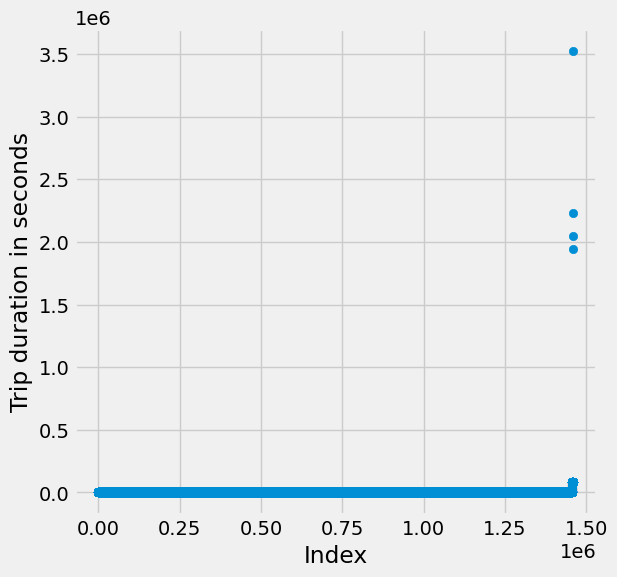

In [9]:
plt.figure(figsize = (6, 6))
plt.scatter(range(len(taxi.trip_duration)), np.sort(taxi.trip_duration.values))
plt.xlabel('Index')
plt.ylabel('Trip duration in seconds')
plt.show()

Interesting! Outliers! So we understand that the metric used in the challenge for which the dataset was used was Root Mean Squared Logarithmic Error.But in our case we won't be using RMSLE because we'll be applying the log function to our target and using RMSE as the metric.

In [10]:
taxi['log_trip_duration'] = np.log(taxi['trip_duration'].values)

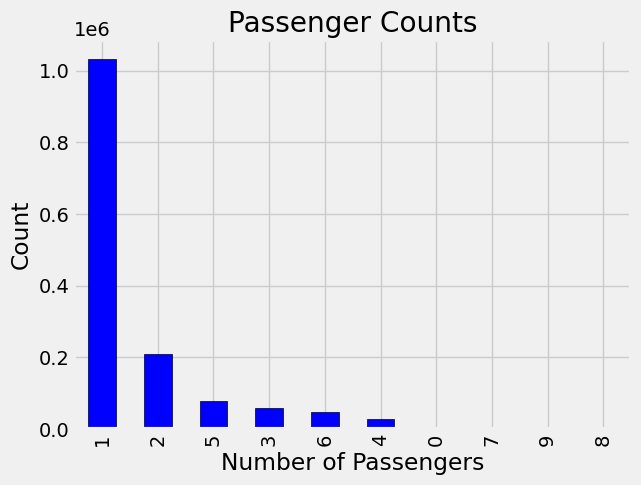

In [11]:
taxi['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

In [12]:
taxi.passenger_count.value_counts()

passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: count, dtype: int64

In [13]:
taxi[taxi.passenger_count==0]

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration
62744,2016-06-06 16:39:09,2016-06-07 16:30:50,0,-73.776367,40.645248,-73.776360,40.645260,85901,11.360951
136519,2016-01-01 05:01:32,2016-01-01 05:01:36,0,-73.993134,40.757473,-73.993294,40.757538,4,1.386294
194288,2016-02-21 01:33:52,2016-02-21 01:36:27,0,-73.946243,40.772903,-73.946770,40.774841,155,5.043425
217765,2016-01-04 12:24:17,2016-01-04 13:01:48,0,-73.815224,40.700081,-73.950699,40.755222,2251,7.719130
263809,2016-05-23 23:37:37,2016-05-23 23:37:45,0,-73.861633,40.705029,-73.861633,40.705029,8,2.079442
278290,2016-02-07 17:23:48,2016-02-07 17:23:57,0,-73.954941,40.687866,-73.954742,40.687862,9,2.197225
301600,2016-01-01 23:52:46,2016-01-02 00:27:18,0,-73.993652,40.757046,-73.918869,40.757793,2072,7.636270
303133,2016-01-05 18:52:20,2016-01-05 18:52:35,0,-73.985291,40.738335,-73.985352,40.738361,15,2.708050
337809,2016-05-22 00:23:15,2016-05-22 00:23:56,0,-73.956718,40.777142,-73.956764,40.776958,41,3.713572
375972,2016-05-31 05:10:23,2016-05-31 05:10:38,0,-73.982468,40.727974,-73.982468,40.728001,15,2.708050


Cabs with 7, 9 people, not strange because there are also limousines that are counted as cabs according to the dataset description. But passenger_count=0 with durations greater than 0, this may be an error on the part of the driver. We can delete these lines (passenger_count==0) especially as we have no information on this data.

In [14]:
taxi = taxi[taxi.passenger_count>0]
taxi.shape

(1458584, 9)

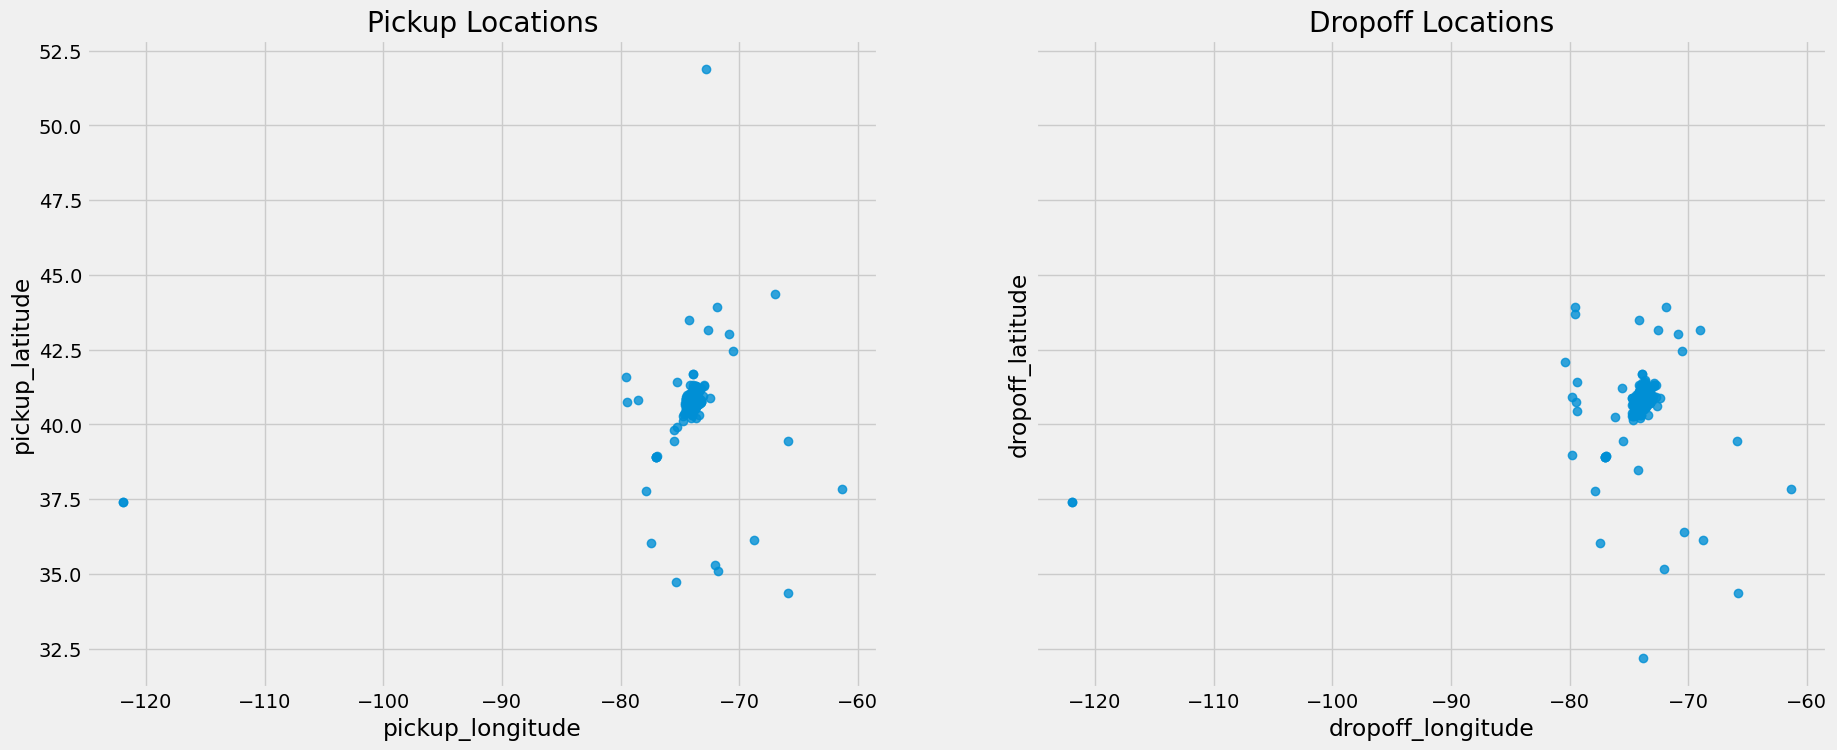

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot(x='pickup_longitude', y='pickup_latitude', fit_reg = False,
            data = taxi, ax = axes[0]);
sns.regplot(x='dropoff_longitude', y='dropoff_latitude', fit_reg = False,
            data = taxi, ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

According to https://www.travelmath.com/cities/New+York,+NY, the coordinates for New York City are:
- longitude = `-74.0063889`
- lattitude = `40.7141667`.
But from the figures, we have coordinates that are clearly outliers, so we need to define an interval for the coordinate attributes.

In [16]:
# Remove latitude and longtiude outliers
taxi = taxi.loc[taxi['pickup_latitude'].between(40, 42)]
taxi = taxi.loc[taxi['pickup_longitude'].between(-75, -72)]
taxi = taxi.loc[taxi['dropoff_latitude'].between(40, 42)]
taxi = taxi.loc[taxi['dropoff_longitude'].between(-75, -72)]

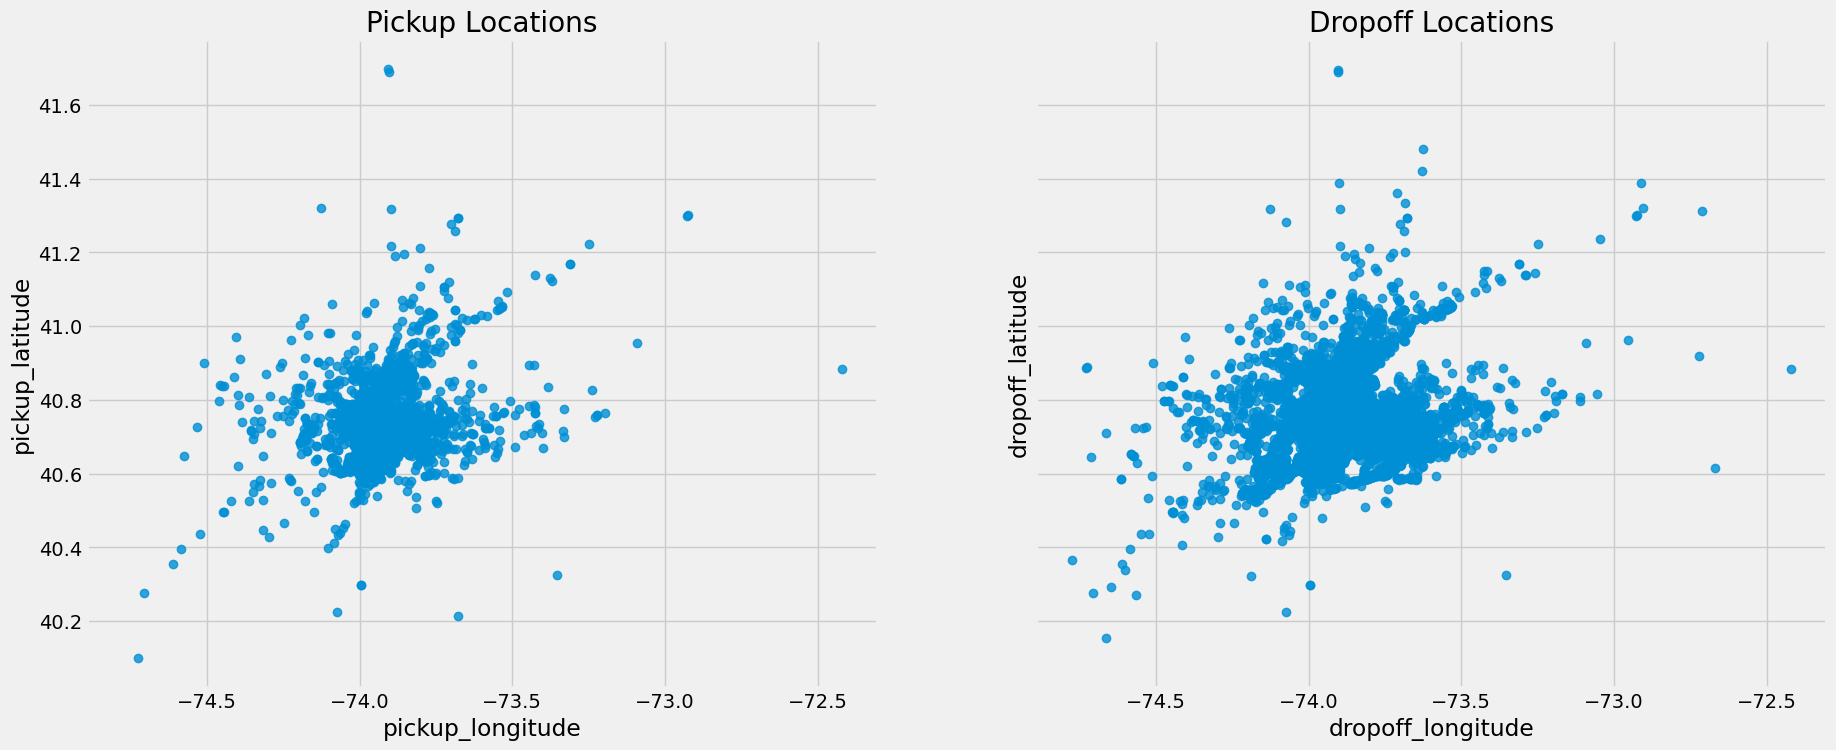

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (20, 8), sharex=True, sharey=True)
axes = axes.flatten()

# Plot Longitude (x) and Latitude (y)
sns.regplot(x='pickup_longitude', y='pickup_latitude', fit_reg = False,
            data = taxi, ax = axes[0]);
sns.regplot(x='dropoff_longitude', y='dropoff_latitude', fit_reg = False,
            data = taxi, ax = axes[1]);
axes[0].set_title('Pickup Locations')
axes[1].set_title('Dropoff Locations');

# Feature Engineering

Let's take a closer look to the pickup and dropoff columns

In [18]:
taxi['pickup_day'] = taxi['pickup_datetime'].dt.day
taxi['pickup_day_name'] = taxi['pickup_datetime'].dt.day_name()

taxi['pickup_month'] = taxi['pickup_datetime'].dt.month
taxi['pickup_weekday'] = taxi['pickup_datetime'].dt.weekday
taxi['pickup_hour'] = taxi['pickup_datetime'].dt.hour

taxi['drop_day'] = taxi['dropoff_datetime'].dt.day
taxi['drop_day_name'] = taxi['dropoff_datetime'].dt.day_name()

taxi['drop_month'] = taxi['dropoff_datetime'].dt.month
taxi['drop_weekday'] = taxi['dropoff_datetime'].dt.weekday
taxi['drop_hour'] = taxi['dropoff_datetime'].dt.hour

gc.collect()

14775

Text(0, 0.5, 'Pickup count')

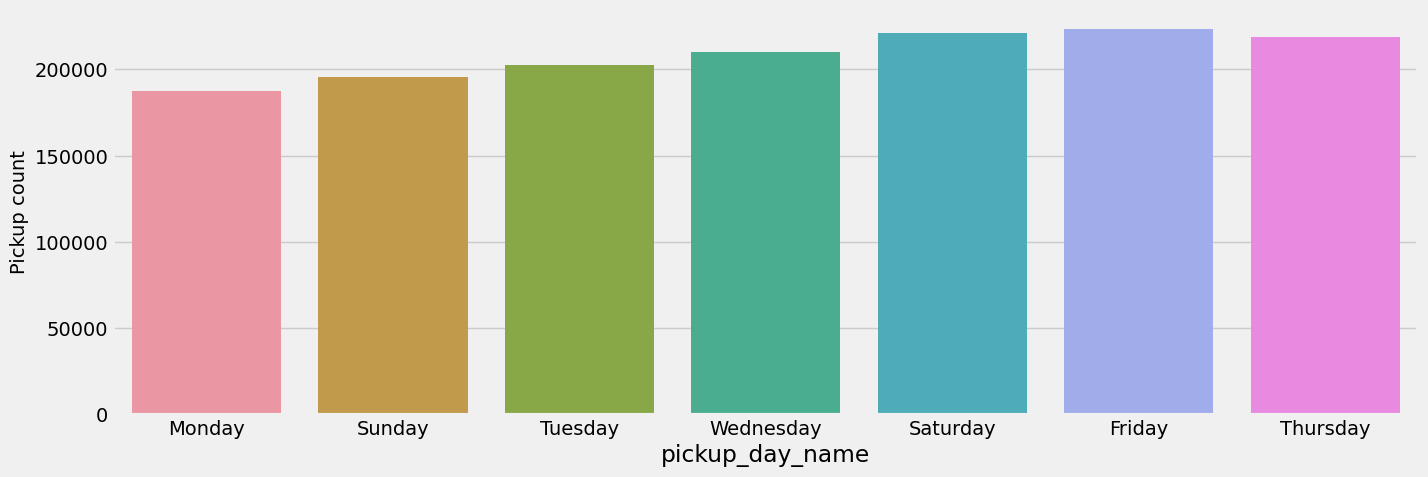

In [19]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='pickup_day_name', data=taxi)
plt.ylabel('Pickup count', fontsize=14)
#taxi = taxi.drop('pickup_day_name', axis=1)

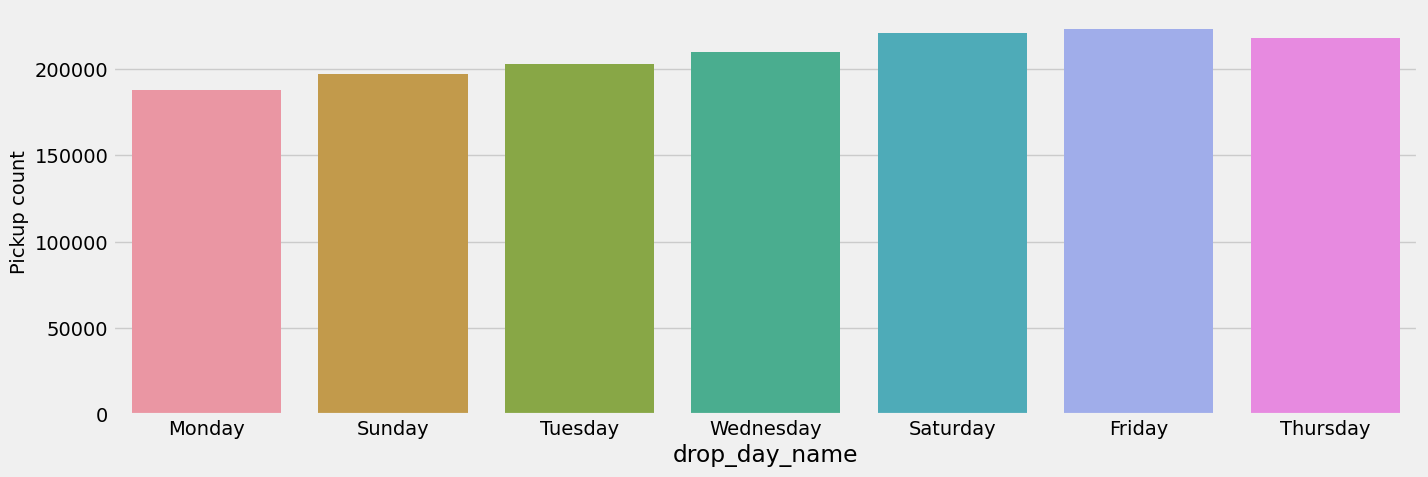

In [20]:
f = plt.figure(figsize=(15,5))
sns.countplot(x='drop_day_name', data=taxi)
plt.ylabel('Pickup count', fontsize=14)
plt.show()
#taxi = taxi.drop('drop_day_name', axis=1)

We see Fridays are the busiest days followed by Saturdays.

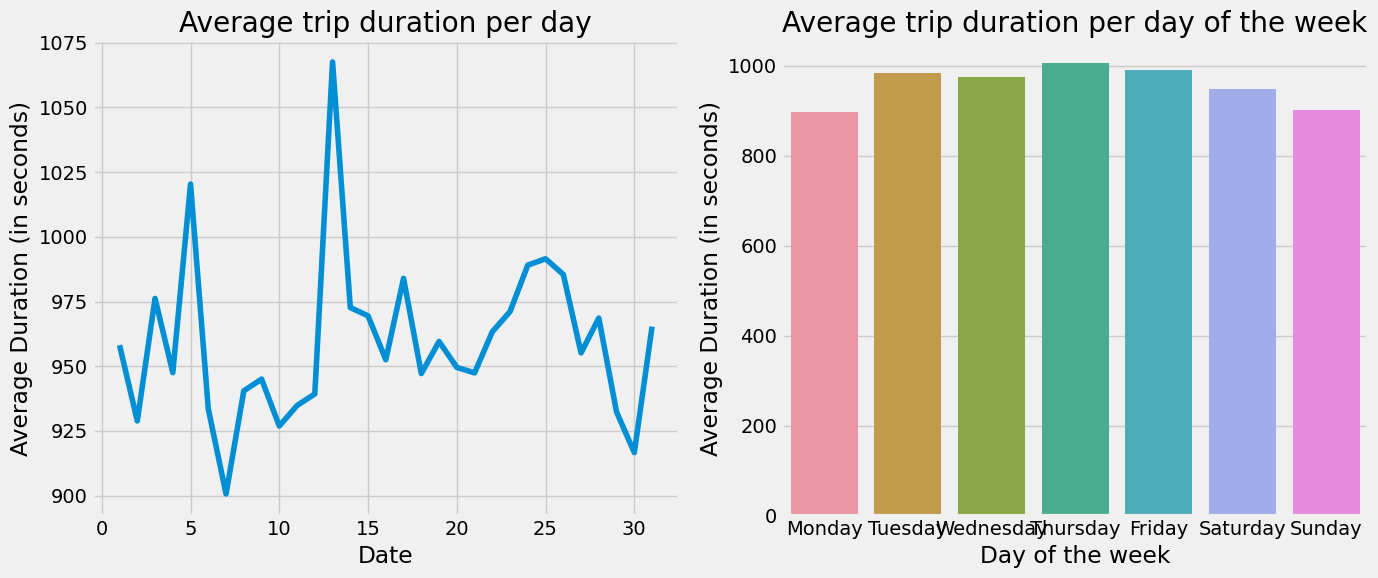

In [21]:
taxi['pickup_weekday'] = taxi['pickup_datetime'].dt.day_name()

average_duration_per_day = taxi.groupby('pickup_day')['trip_duration'].mean().reset_index()

# Calculate the average trip duration per day of the week
average_duration_per_weekday = taxi.groupby('pickup_weekday')['trip_duration'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
).reset_index()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.lineplot(x='pickup_day', y='trip_duration', data=average_duration_per_day)
plt.title('Average trip duration per day')
plt.xlabel('Date')
plt.ylabel('Average Duration (in seconds)')

plt.subplot(1, 2, 2)
sns.barplot(x='pickup_weekday', y='trip_duration', data=average_duration_per_weekday)
plt.title('Average trip duration per day of the week')
plt.xlabel('Day of the week')
plt.ylabel('Average Duration (in seconds)')

plt.tight_layout()
plt.show()

### Calculate Distance between points using Haversine distance
We also saw during dataset exploration that we have coordinates in the form of longitude and latitude for pickup and dropoff. But, we can’t really gather any insights or draw conclusions from that.
So, the most obvious feature that we can extract from this is distance. To calculate a more realistic distance between the pickup and dropoff, we can use the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula).

The formula for Haversine distance is:

$${\displaystyle =2r\arcsin \left({\sqrt {\sin ^{2}\left({\frac {\varphi _{2}-\varphi _{1}}{2}}\right)+\cos(\varphi _{1})\cos(\varphi _{2})\sin ^{2}\left({\frac {\lambda _{2}-\lambda _{1}}{2}}\right)}}\right)}$$

where r is the radius of the Earth. The end units will be in km.The following function is from Stack Overflow answer: https://stackoverflow.com/a/29546836

In [22]:
# Radius of the earth in kilometers
R = 6378

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c

    return km

In [23]:
taxi['haversine'] =  haversine_np(taxi['pickup_longitude'], taxi['pickup_latitude'],
                         taxi['dropoff_longitude'], taxi['dropoff_latitude'])
gc.collect()

7660

In [24]:
taxi[taxi.haversine==0]

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,pickup_day,pickup_day_name,pickup_month,pickup_weekday,pickup_hour,drop_day,drop_day_name,drop_month,drop_weekday,drop_hour,haversine
246,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,227,5.424950,29,Monday,2,Monday,18,29,Monday,2,0,18,0.0
291,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,1109,7.011214,10,Tuesday,5,Tuesday,18,10,Tuesday,5,1,18,0.0
407,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,947,6.853299,16,Monday,5,Monday,23,16,Monday,5,0,23,0.0
702,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,580,6.363028,25,Monday,1,Monday,19,25,Monday,1,0,19,0.0
1620,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,27,3.295837,27,Wednesday,1,Wednesday,22,27,Wednesday,1,2,22,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456399,2016-02-17 08:57:04,2016-02-17 09:18:28,1,-73.978859,40.756721,-73.978859,40.756721,1284,7.157735,17,Wednesday,2,Wednesday,8,17,Wednesday,2,2,9,0.0
1456627,2016-02-06 22:01:40,2016-02-06 22:03:47,1,-73.963554,40.768517,-73.963554,40.768517,127,4.844187,6,Saturday,2,Saturday,22,6,Saturday,2,5,22,0.0
1456989,2016-03-12 07:37:16,2016-03-12 07:46:42,1,-73.984848,40.728222,-73.984848,40.728222,566,6.338594,12,Saturday,3,Saturday,7,12,Saturday,3,5,7,0.0
1457114,2016-04-09 20:34:21,2016-04-09 20:44:53,1,-73.965981,40.770988,-73.965981,40.770988,632,6.448889,9,Saturday,4,Saturday,20,9,Saturday,4,5,20,0.0


Distances equal to 0 while their trip duration are positive values. This could be due to input errors, technical problems with the cab tracking system, or other factors.

In [25]:
taxi = taxi.loc[taxi.haversine>0]

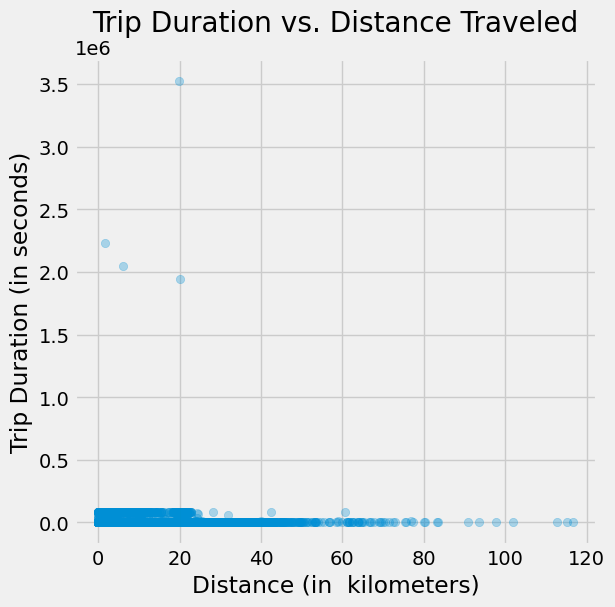

In [26]:
# Plotting the scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(taxi['haversine'], taxi['trip_duration'], alpha=0.3)
plt.title('Trip Duration vs. Distance Traveled')
plt.xlabel('Distance (in  kilometers)')
plt.ylabel('Trip Duration (in seconds)')
plt.show()

As a final step, we can find the correlations between features and trip_duration.

In [27]:
taxi

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,pickup_day,pickup_day_name,pickup_month,pickup_weekday,pickup_hour,drop_day,drop_day_name,drop_month,drop_weekday,drop_hour,haversine
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,6.120297,14,Monday,3,Monday,17,14,Monday,3,0,17,1.500167
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,6.496775,12,Sunday,6,Sunday,0,12,Sunday,6,6,0,1.807491
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,7.661056,19,Tuesday,1,Tuesday,11,19,Tuesday,1,1,12,6.392114
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,6.061457,6,Wednesday,4,Wednesday,19,6,Wednesday,4,2,19,1.487131
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,6.075346,26,Saturday,3,Saturday,13,26,Saturday,3,5,13,1.189894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,778,6.656727,8,Friday,4,Friday,13,8,Friday,4,4,13,1.226426
1458640,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,655,6.484635,10,Sunday,1,Sunday,7,10,Sunday,1,6,7,6.056483
1458641,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,764,6.638568,22,Friday,4,Friday,6,22,Friday,4,4,7,7.833203
1458642,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,373,5.921578,5,Tuesday,1,Tuesday,15,5,Tuesday,1,1,16,1.093764


In [28]:
taxi = taxi.drop(['pickup_datetime', 'dropoff_datetime', 'pickup_day_name', 'pickup_weekday', 'drop_day_name'], axis=1)

In [29]:
taxi

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,pickup_day,pickup_month,pickup_hour,drop_day,drop_month,drop_weekday,drop_hour,haversine
0,1,-73.982155,40.767937,-73.964630,40.765602,455,6.120297,14,3,17,14,3,0,17,1.500167
1,1,-73.980415,40.738564,-73.999481,40.731152,663,6.496775,12,6,0,12,6,6,0,1.807491
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,7.661056,19,1,11,19,1,1,12,6.392114
3,1,-74.010040,40.719971,-74.012268,40.706718,429,6.061457,6,4,19,6,4,2,19,1.487131
4,1,-73.973053,40.793209,-73.972923,40.782520,435,6.075346,26,3,13,26,3,5,13,1.189894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,4,-73.982201,40.745522,-73.994911,40.740170,778,6.656727,8,4,13,8,4,4,13,1.226426
1458640,1,-74.000946,40.747379,-73.970184,40.796547,655,6.484635,10,1,7,10,1,6,7,6.056483
1458641,1,-73.959129,40.768799,-74.004433,40.707371,764,6.638568,22,4,6,22,4,4,7,7.833203
1458642,1,-73.982079,40.749062,-73.974632,40.757107,373,5.921578,5,1,15,5,1,1,16,1.093764


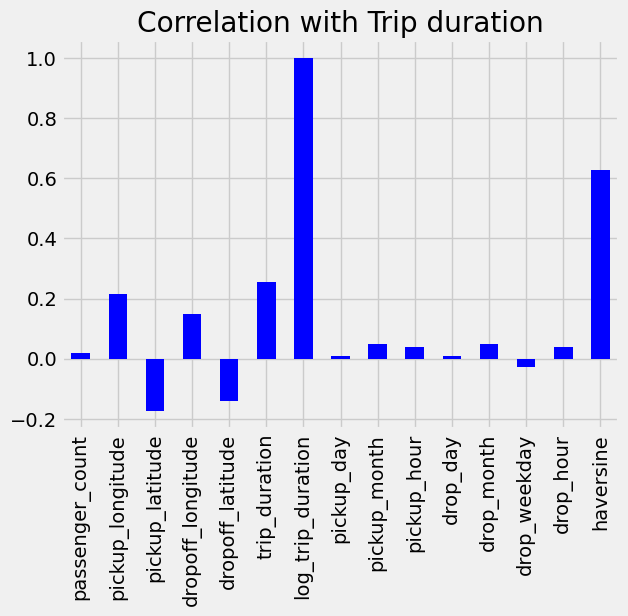

In [30]:
corrs = taxi.corr()
corrs['log_trip_duration'].plot.bar(color = 'b');
plt.title('Correlation with Trip duration');

# Machine Learning

## Split Into Training and Testing Sets

In [31]:
# Separate out the features and targets
features = taxi.drop(columns=['log_trip_duration', 'trip_duration'])
targets = pd.DataFrame(taxi['log_trip_duration'])

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)

(1016872, 13)
(435803, 13)
(1016872, 1)


### Establish a Baseline

To make sure that machine learning is even applicable to the task, we should compare these predictions to a naive guess. For a regression task, this can be as simple as the average value of the target in the training data.

## Metric: Root Mean Squared  Error.
The recommended metric was Root Mean Squared Logarithmic Error, but as we've applied the log function to our target, we'll use `Root Mean Squared Error`.

In [34]:
from sklearn.metrics import mean_squared_error


def metrics(train_pred, test_pred, y_train, y_test):
    """Calculate metrics:
       Root mean squared error"""

    # Root mean squared error
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))


    return train_rmse, test_rmse

def evaluate(model, features, X_train, X_test, y_train, y_test):

    # Make predictions
    train_pred = model.predict(X_train[features])
    valid_pred = model.predict(X_valid[features])

    # Get metrics
    train_rmse, test_rmse = metrics(train_pred, valid_pred, y_train, y_valid)

    print(f'Training:   rmse = {round(train_rmse, 2)}')
    print(f'Testing:    rmse = {round(test_rmse, 2)}')

In [35]:
train_mean = y.mean()

# Create list of the same prediction for every observation
train_preds = [train_mean for _ in range(len(y))]
test_preds = [train_mean for _ in range(len(y_test))]

tr, vr = metrics(train_preds, test_preds, y, y_test)

print(f'Baseline Training:   rmse = {round(tr, 2)}')
print(f'Baseline Testing: rmse = {round(vr, 2)}')

gc.collect()

Baseline Training:   rmse = 0.79
Baseline Testing: rmse = 0.79


4896

Our current model (baseline) has an RMSE of 0.79, which is a first reference. We should now build more sophisticated models to see if they can improve this performance.

## Evaluating and Comparing Machine Learning Models

### Scaling Features

In [35]:
from sklearn.preprocessing import  MinMaxScaler

In [36]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

gc.collect()

4896

In [37]:
# Convert y to one-dimensional array (vector)
y = np.array(y).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

gc.collect()

0

### Models to Evaluate

In [38]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def fit_and_evaluate(model):

    model.fit(X, y)

    model_pred = model.predict(X_test)
    model_rmse = rmse(y_test, model_pred)

    return model_rmse

In [39]:
# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [41]:
lr = LinearRegression()
lr_rmse = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: RMSE = %0.4f' % lr_rmse)

Linear Regression Performance on the test set: RMSE = 0.5781


In [42]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_rmse = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: RMSE = %0.4f' % random_forest_rmse)

gc.collect()

Random Forest Regression Performance on the test set: RMSE = 0.3904


27

In [43]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_rmse = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: RMSE = %0.4f' % gradient_boosted_rmse)

gc.collect()

Gradient Boosted Regression Performance on the test set: RMSE = 0.4349


0

In [44]:
xgb = XGBRegressor(random_state=42)
xgb_rmse = fit_and_evaluate(xgb)

print('Extreme Gradient Boosting Regression Performance on the test set: RMSE = %0.4f' % xgb_rmse)

gc.collect()

Extreme Gradient Boosting Regression Performance on the test set: RMSE = 0.3742


43

155

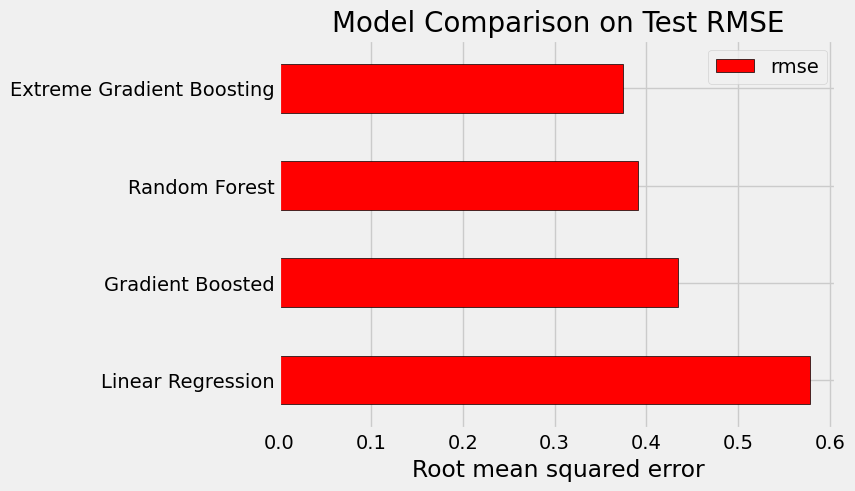

In [45]:
plt.style.use('fivethirtyeight')

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression',
                                           'Random Forest', 'Gradient Boosted',
                                             'Extreme Gradient Boosting'],
                                 'rmse': [lr_rmse, random_forest_rmse,
                                         gradient_boosted_rmse , xgb_rmse]})

# Horizontal bar chart of test mae
model_comparison.sort_values('rmse', ascending = False).plot(x = 'model', y = 'rmse', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Root mean squared error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test RMSE', size = 20);

gc.collect()

After this training, `Extreme Gradient Boosting` outperformed the other models in terms of performance, and we're going to optimize it to improve its performance.

# Model Optimization
## Hyperparameter Tuning with Random Search and Cross Validation

In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [47]:
random_grid = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
    'max_depth': [2, 3, 5, 10, 15],
    'min_child_weight': [1, 2, 3, 4]
}

In [48]:
from sklearn.model_selection import RandomizedSearchCV
model = XGBRegressor()

# Set up the random search with 5-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=random_grid,
                               cv=5,
                               n_iter=10,
                               n_jobs=-1,
                               scoring = "neg_mean_squared_error",
                               verbose = 1,
                               return_train_score = True,
                               random_state=42)

gc.collect()

3761

In [49]:
random_cv.fit(X, y)

gc.collect()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


74

In [50]:
random_cv.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [52]:
print("Best RMSE  score  :", np.sqrt(-random_cv.best_score_))

Best RMSE  score  : 0.3427161405863245


### Evaluate our System on the Test Set

We will use the best model from hyperparameter tuning to make predictions on the testing set.

In [40]:
final_model = XGBRegressor(learning_rate=0.3,
                           max_depth=10,
                           min_child_weight=1,
                          n_estimators=500)

In [41]:
final_model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
final_pred = final_model.predict(X_test)

In [43]:
print('Final model performance on the test set:   RMSE = %0.4f.' % rmse(y_test, final_pred))

Final model performance on the test set:   RMSE = 0.3371.


Despite having limited resources at our disposal (CPU, RAM), we were able to optimize our model and achieve slightly better performance than our basic model(`RMSE = 0.3371` on the test set).

# Interprete the Model
## Feature Importances

In [58]:
features.columns

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_day', 'pickup_month',
       'pickup_hour', 'drop_day', 'drop_month', 'drop_weekday', 'drop_hour',
       'haversine'],
      dtype='object')

In [59]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(features.columns), 
                                'importance': final_model.feature_importances_})

feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head()

,feature,importance
0,haversine,0.473261
1,drop_hour,0.111177
2,drop_month,0.091753
3,pickup_hour,0.065213
4,drop_day,0.057856


Well, as we all know, the duration of a journey depends on a number of parameters, but it's particularly dependent on distance. That's why our feature `(distance haversine)` has a fairly wide margin in predicting travel time.

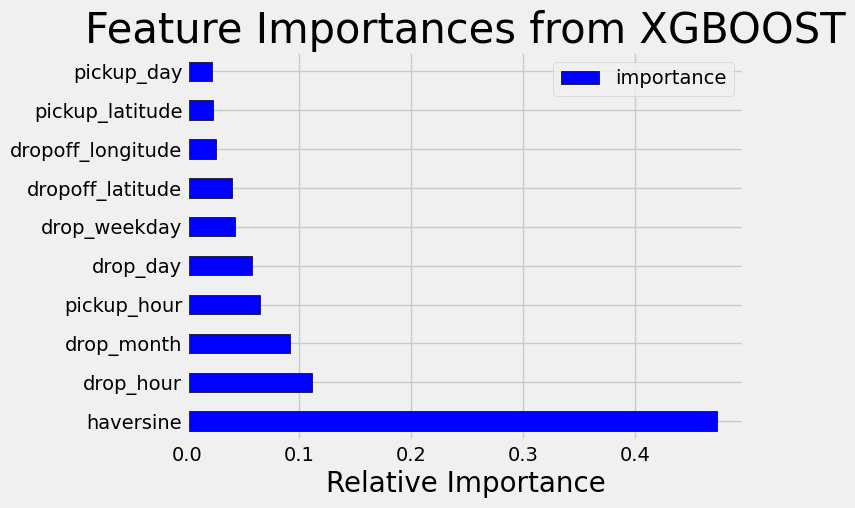

In [61]:
# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from XGBOOST', size = 30);

## Model persistence using joblib
Save the final model:

In [62]:
import joblib

joblib.dump(final_model, "TaxiTimePredictor.pkl")

['TaxiTimePredictor.pkl']